# Cosmological Parameter Estimation

This lecture is signi

***
# Preamble

We will first do some setup that lets us make plots inline in the notebook.
You can run each cell by pressing Shift-Enter.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

***
# From yesterday: The Model Function

In [3]:
from astropy.cosmology import LambdaCDM

Copy in your astropy `model` function for the  from the last lecture here.  If you didn't get a working function, have a look at the answer notebook

In [4]:
# Complete this function
def model(H0, Omega_matter, Omega_lambda, M0, z):
    cosmo = LambdaCDM(H0=H0, Om0=Omega_matter, Ode0=Omega_lambda)
    mu = cosmo.distmod(z)
    m = mu.value + M0
    return m

***

# Exercise 3: Loading and exploring supernova data

The *Pantheon* supernova analysis project measured the apparent magnitude of a large sample of supernovae, standardising them to control any differences between them and very carefully calibrating them.  They grouped them into 40 bins of data, which we have extracted and supplied with this notebook.

In this exercise we will load the Pantheon data and explore it.

In later exercises we will use Pantheon to constrain cosmological parameters.

Load in the Pantheon data from the file `data.txt`.  The two columns in it are *redshift* `z_obs` and *apparent magnitude* `m_obs`.

HINT: Use the function `np.loadtxt` to do this quickly, but then you'll need to pull out the two columns separately.

In [5]:
# write your code here
z_obs, m_obs = np.loadtxt("./data.txt").T

Make a plot of the data points in the file, showing $m$ as a function of $z$

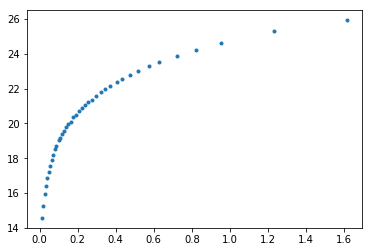

In [6]:
#write your code here
plt.plot(z_obs, m_obs, '.')

Now use the function you wrote in the last exercise to make a theory prediction for $m$ for the same parameters we have used before:
```
    H0 = 72.0
    Omega_matter = 0.3
    Omega_lambda = 0.7
    M0 = -19.3
```
Add it to your plot.
How good is the fit?

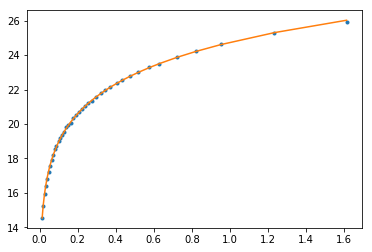

In [7]:
# Write your code here
m_pred = model(72., 0.3, 0.7, -19.3, z_obs)
plt.plot(z_obs, m_obs, '.')
plt.plot(z_obs, m_pred)

Load the covariance matrix `C` of the Pantheon data points from the file `cov.txt`.  Check its shape is 40 x 40.

In [8]:
# write your code here.
C = np.loadtxt("./cov.txt")
print(C.shape)

(40, 40)


Use the covariance matrix to work out the standard deviation of each data point as an array.

The covariance $C_{ij}$ between two data points $i$ and $j$ is the expectation $E\left[(x_i - \bar{x_i}) \cdot (x_j - \bar{x_j})\right]$.  The variance of a single data point $i$ is $E\left[(x_i - \bar{x_i})^2\right]$, so think about where the variance is in the covariance matrix.

HINT: `np.diagonal` and `np.sqrt` may be of use.

In [9]:
sigma = np.sqrt(np.diagonal(C))

Use this to make the same plot as above, but with error bars.

HINT: `plt.errorbar`.  The error bars will be tiny!

<ErrorbarContainer object of 3 artists>

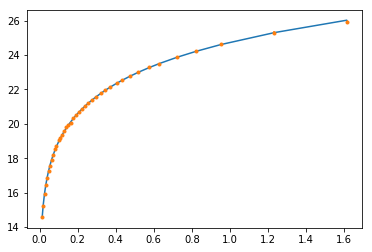

In [10]:
plt.plot(z_obs, m_pred)
plt.errorbar(z_obs, m_obs, sigma, fmt='.')

Compute the inverse `invC` of the matrix `C`

HINT: `np.linalg.inv`

In [11]:
# write your code here.
invC = np.linalg.inv(C)

For this set of parameters, compute the Gaussian log-likelihood:

$-\frac{1}{2} * (m_\textrm{obs} - m_\textrm{pred})^T \cdot C^{-1} \cdot(m_\textrm{obs} - m_\textrm{pred})$

Roughly speaking a good Gaussian log-likelihood should be about $-\frac{1}{2} n_\mathrm{data}$.  Is this a good fit?

Note that we've omitted a constant term at the front, which will have no effect here.


HINT: Use the $@$ sign to do the The matrix (and dot) product in numpy

In [12]:
# write your code here
L = -0.5 * (m_obs - m_pred) @ invC @ (m_obs - m_pred)
print(L)

-23.47495183524257


Finally, write a function `loglike` that takes a vector of your four parameters, `[H0, Omega_matter, Omega_de, M0]`, and computes their likelihood given the observed data.

Astropy will not work if a negative value of Omega_matter or H0 is supplied. Make your function check for this and return -infinity if this happens.

In [13]:
# write your code here
def loglike(p):
    H0, Omega_matter, Omega_de, M0 = p
    if Omega_matter < 0 or H0 < 0:
        return -np.inf
    m_pred = model(H0, Omega_matter, Omega_de, M0, z_obs)
    d = m_pred - m_obs
    L = -0.5 * d @ invC @ d
    return L

## Exercise 4: Sampling

If we had to explore a fine grid in our likelihood's four parameters it would take days

Models for other cosmology data sets might have more than 30 parameters, which would take longer than the lifetime of the Universe to explore like this!

We will use the Metropolis-Hastings algorithm that we described in the lectures to explore this parameter space instead, to make it take a manageable time.

We will first need a proposal function, which should returns a random jump from a current position in parameter space to one that is nearby.

Write a proposal that adds a small Gaussian-distributed jump from the current point `p` in each direction, and returns the new point.  Since the parameters are all different they need different sized jumps - you should make the typical size be these values for the different parameters:

```
 H0: 0.5
 omega_matter: 0.01
 omega_lambda: 0.01
 M0: 0.025
```

HINT: `np.random.normal(n)` generates `n` Gaussian-distributed random numbers with standard deviation 1.

In [14]:
# write your code here
def propose(p):
    return p + np.random.normal(size=p.size) * np.array([0.5, 0.01, 0.01, 0.025])

Now we will write a Metropolis-Hastings MCMC sampling process.

Write a code to perform the MH loop that we described in lectures, with these features:
- record the value of the new parameter set each time through the loop.
- record the likelihood each iteration.
- do 100,000 iterations of the loop
- start from the point `[72., 0.3, 0.7, -19.3]`
- count the number of time the proposal is accepted.  If everything is working, about 16% of the jumps should be accepted in this case.

This will take a few minutes - you might want to print something out every 5000 samples to give you an idea of progress.

HINT: It's easiest to pre-allocate the arrays of parameter values and likelihoods. It's also easier always to work in log-likelihoods.  This will take a few minutes to run.

In [15]:
# write your code here

# First make an array describing the starting point of the iteration
p = np.array([72., 0.3, 0.7, -19.3])
Lp = loglike(p)

# And make space to store the results
N = 100000
chain = np.zeros((N, 4))
likes = np.zeros(N)

# Main MCMC loop
acc=0
for i in range(N):
    if i%5000 == 0:
        print(i)
    # new possible point and its likelihood
    q = propose(p)
    Lq = loglike(q)
    # Metropolis acceptance criterion
    if (Lq > Lp) or Lq - Lp > np.log(np.random.uniform()):
        p = q
        Lp = Lq
        # count accepts
        acc += 1
    # store next point, whether it's the same or not
    chain[i] = p
    likes[i] = Lp
# Print acceptance fraction
print(acc/N)
    

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
0.16546


Plot the value of each parameter throughout the chain.  Comment on the performance of the proposal.

Why are some parameters better explored than others?  How could you improve the performance?


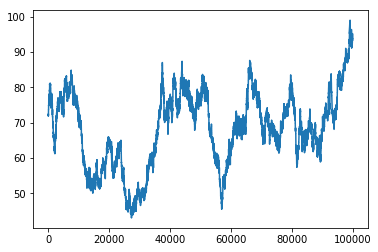

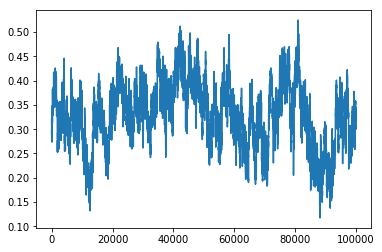

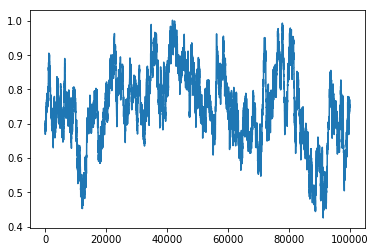

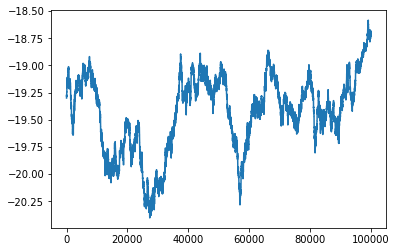

In [16]:
# write your code here
for i in range(4):
    plt.figure()
    plt.plot(chain[:,i])

Make a point plot of H0 versus M0 across the chain.

Compare this to your grid plot earlier.

HINT: Use a comma `','` as the marker type to make it easier to see.

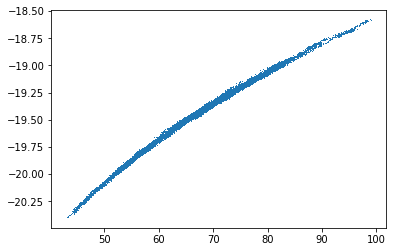

In [17]:
# write your code here
plt.plot(chain[:,0], chain[:,3], ',')

Make a scatter plot of omega_matter versus omega_lambda for the full chain.

Use the likelihood value as the color of each point, and size=1 for each.

HINT: Use `plt.scatter`


Text(0, 0.5, '$Omega_lam$')

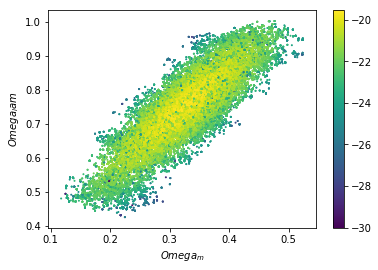

In [18]:
# write your code here
plt.scatter(chain[:,1], chain[:,2], s=1, c=likes[:])
plt.colorbar()
plt.xlabel("$Omega_m$")
plt.ylabel("$Omega_lam$")

Make a histogram of each parameter across the chain..

Use the log-likelihood value as the color of each point, and size `s=1` for each.

HINT: Use `plt.hist`

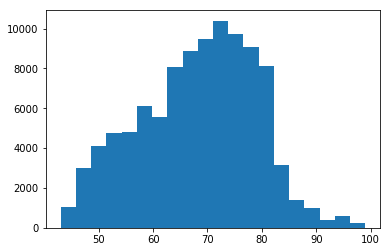

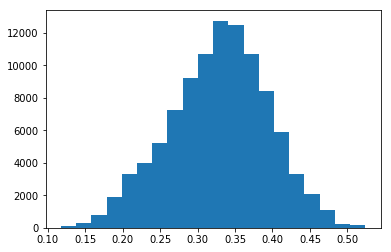

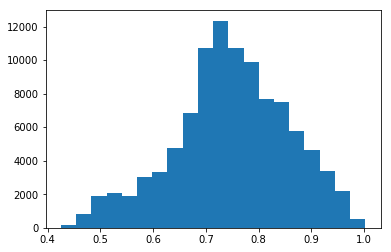

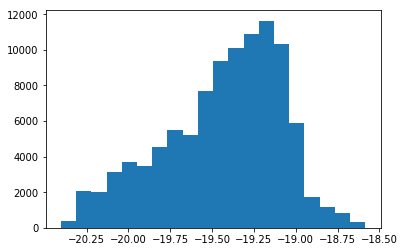

In [19]:
# write your code here
for i in range(4):
    plt.figure()
    plt.hist(chain[:,i], bins=20)


Compute the mean and standard deviation of Omega_matter and Omega_lambda, across the chain.
This estimate is what this data set tells us about these parameters.

In [20]:
# write your code here
print('Omega_matter = {:.3f} ± {:.3f}'.format(chain[:,1].mean(), chain[:,1].std()))
print('Omega_lambda = {:.3f} ± {:.3f}'.format(chain[:,2].mean(), chain[:,2].std()))

Omega_matter = 0.328 ± 0.066
Omega_lambda = 0.748 ± 0.108


You can also work out derived parameters from the chain.

Plot a histogram of $\Omega_k = 1 - \Omega_m - \Omega_\lambda$, and compute its mean and standard deviation.

HINT: Use `plt.hist`, `np.mean`, and `np.std`.

Omega_k = -0.076 ± 0.168


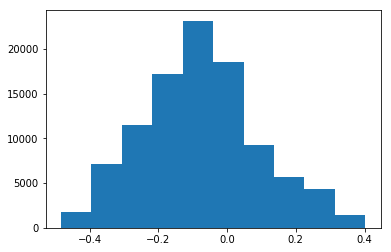

In [21]:
# Write your code here
omk = 1 - chain[:,1] - chain[:,2]
print('Omega_k = {:.3f} ± {:.3f}'.format(omk.mean(), omk.std()))
_ = plt.hist(omk)

# Further exercises

- Improve your Metropolis-Hastings sampler by:
    - taking the posterior covariance of the transpose of your existing chain
    - finding the Cholesky decomposition `chol` (matrix square-root) of the posterior covariance
    - making a new proposal `chol @ r` where `r` is a vector of random Gaussian numbers with variance 1

